In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Open SOS Measurement Dataset, extract measurements

In [66]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)


alt.Chart(
    tidy_df[(tidy_df.time < '20221220') & (tidy_df["measurement"].isin(['w','v','u']))].query("height == 1")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color("measurement:N"),
    alt.Facet('tower:N'),
).properties(width=300, height=300)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Add absolute humidity measurements by converting hygrometer measurements

In [67]:
any(tidy_df[tidy_df.measurement=='mixing ratio'].height.unique() == 1)

True

In [68]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

# Calibrate gas analyzer measurements

## Assume that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [69]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [70]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [71]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.128948,2.080217,0.048731
1,h2o_10m_d,d,10.0,1.264312,2.080217,-0.815905
2,h2o_10m_ue,ue,10.0,1.091568,2.080217,-0.988648
3,h2o_10m_uw,uw,10.0,1.608586,2.080217,-0.471630
4,h2o_15m_c,c,15.0,1.954592,2.065882,-0.111290
5,h2o_1m_c,c,1.0,2.264087,2.113118,0.150968
6,h2o_1m_d,d,1.0,1.700445,2.113118,-0.412673
7,h2o_1m_ue,ue,1.0,1.310203,2.113118,-0.802916
8,h2o_1m_uw,uw,1.0,1.502313,2.113118,-0.610806
9,h2o_20m_c,c,20.0,0.934247,2.056363,-1.122116


## Update dataset with corrections

In [72]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
106,2022-11-30 00:00:00,h2o_1m_ue,0.010025,1.0,ue,Water vapor density
366,2022-11-30 00:00:00,h2o_1m_c,0.786468,1.0,c,Water vapor density
398,2022-11-30 00:00:00,h2o_10m_d,0.097003,10.0,d,Water vapor density
403,2022-11-30 00:00:00,h2o_3m_c,0.913812,3.0,c,Water vapor density
408,2022-11-30 00:00:00,h2o_1m_d,0.743467,1.0,d,Water vapor density
...,...,...,...,...,...,...
5923925,2023-05-09 17:30:00,h2o_10m_d,1.786908,10.0,d,Water vapor density
5923932,2023-05-09 17:30:00,h2o_3m_d,2.589736,3.0,d,Water vapor density
5923937,2023-05-09 17:30:00,h2o_1m_d,NaN,1.0,d,Water vapor density
5923955,2023-05-09 17:30:00,h2o_1m_c,3.183305,1.0,c,Water vapor density


In [73]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [74]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [75]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [76]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]

alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/796244343.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Create wide df

In [77]:
vars = [
    'dir_1m_ue', 'u_h2o__1m_ue', 'v_h2o__1m_ue', 'w_h2o__1m_ue',     'u_1m_ue',  'v_1m_ue',  'w_1m_ue', 
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_1m_uw', 'u_h2o__1m_uw', 'v_h2o__1m_uw', 'w_h2o__1m_uw',     'u_1m_uw',  'v_1m_uw',  'w_1m_uw', 
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_1m_d', 'u_h2o__1m_d', 'v_h2o__1m_d', 'w_h2o__1m_d',        'u_1m_d',   'v_1m_d',   'w_1m_d',  
    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_1m_c', 'u_h2o__1m_c', 'v_h2o__1m_c', 'w_h2o__1m_c',        'u_1m_c',   'v_1m_c',   'w_1m_c',   'specifichumidity_1m_c',    'airdensity_1m_c',
    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 
    # 'T_12m_c',
      'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')


assert len(vars) == len(pivot_df.columns.unique())

In [78]:
set(vars).difference(set(pivot_df.columns.unique()))

set()

In [79]:
[ v in tidy_df.variable.unique() for v in vars ]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [80]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Create table with instrument location info 

We use a file with theodolite/GPS readings provided by NCAR. 

In [81]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

# Create tables

## Wind field measurements

In [82]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin([1,3,10])]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-30 00:00:00  0.8441 -2.0020  0.0043  0.8239 -1.8625  0.0176  0.7622   
2022-11-30 00:30:00 -0.2592 -1.0267  0.0187 -0.1716 -1.0262  0.0146 -0.3245   
2022-11-30 01:00:00  0.2994 -1.1333  0.0152  0.3491 -1.0742  0.0246  0.2866   
2022-11-30 01:30:00  0.6550 -1.6003  0.0100  0.6431 -1.4701  0.0209  0.6044   
2022-11-30 02:00:00 -0.2898 -0.8685  0.0139 -0.2472 -0.8933  0.0192 -0.3630   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-30 00:00:00 -1.9373 -0.0059  0.3113  ... -0.0388  2.5207 -2.1899   
2022-11-30 00:30:00 -1.0931 -0.0073 -0.2331  ...  0.0106 -0.0728 -0.8174   
2022-11-30 01:00:00 -1.1269 -0.0039  0.0882  ... -0.0098  0.6075 -0.6620   
2022-11-30 01:30:00 -1.5537 -0.0071  0.1304  ... -0.0476  1.8980 -1.5049   
2022-11-30 02:00:00 -0.9752 -0.0117 -0.2955  ...  0.0165 -0.0233 -0.5845   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-30 00:00:00  0.0375  2.2067 -2.3721  0.0820  1.9061 -2.7110  0.0423  
2022-11-30 00:30:00  0.0636 -0.2530 -0.7707  0.0735 -0.2273 -0.7750  0.0326  
2022-11-30 01:00:00  0.0484  0.4626 -0.7353  0.0680  0.4762 -0.8680  0.0240  
2022-11-30 01:30:00  0.0125  1.7292 -1.6852  0.0385  1.4612 -2.0031 -0.0316  
2022-11-30 02:00:00  0.0682 -0.1797 -0.4798  0.0999 -0.0708 -0.5145  0.0109  

[5 rows x 36 columns]

## Turbulent water vapor flux measurements

In [83]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin([1,3,10])]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-30 00:00:00 -0.0023  0.0060 -0.0008 -0.0013  0.0067 -0.0008  0.0005   
2022-11-30 00:30:00 -0.0122  0.0142 -0.0007 -0.0032  0.0118 -0.0005 -0.0000   
2022-11-30 01:00:00 -0.0024  0.0032 -0.0003  0.0033  0.0017 -0.0001 -0.0000   
2022-11-30 01:30:00 -0.0007 -0.0005 -0.0004  0.0026 -0.0012 -0.0003  0.0004   
2022-11-30 02:00:00 -0.0013  0.0058 -0.0004 -0.0003  0.0132 -0.0001  0.0004   

height                                      ...    10.0                  \
tower                                   uw  ...       c       d           
measurement          v_h2o_ w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                        ...                           
2022-11-30 00:00:00 -0.0009    0.0  0.0083  ...  0.0011 -0.0253  0.0075   
2022-11-30 00:30:00  0.0000    0.0  0.0039  ...  0.0005 -0.0213  0.0102   
2022-11-30 01:00:00 -0.0000   -0.0  0.0056  ... -0.0006 -0.0098  0.0011   
2022-11-30 01:30:00 -0.0002   -0.0 -0.0001  ...  0.0004 -0.0119  0.0032   
2022-11-30 02:00:00 -0.0001   -0.0 -0.0005  ... -0.0004 -0.0088  0.0135   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-30 00:00:00  0.0009 -0.0038  0.0051 -0.0004 -0.0298  0.0238  0.0002  
2022-11-30 00:30:00  0.0005 -0.0119  0.0123  0.0005 -0.0179  0.0178  0.0006  
2022-11-30 01:00:00 -0.0003 -0.0048  0.0034  0.0003 -0.0110  0.0028  0.0007  
2022-11-30 01:30:00  0.0006 -0.0108  0.0058 -0.0006 -0.0108  0.0062 -0.0002  
2022-11-30 02:00:00 -0.0004  0.0060  0.0244 -0.0002 -0.0002  0.0046 -0.0013  

[5 rows x 36 columns]

## Humidity measurements

In [84]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df[abs_hum_field_df.height == 1]

,time,variable,value,height,tower,measurement
366,2022-11-30 00:00:00,h2o_1m_c,0.635500,1.0,c,Water vapor density
1168,2022-11-30 00:30:00,h2o_1m_c,0.734797,1.0,c,Water vapor density
1775,2022-11-30 01:00:00,h2o_1m_c,0.767051,1.0,c,Water vapor density
2545,2022-11-30 01:30:00,h2o_1m_c,0.724239,1.0,c,Water vapor density
3461,2022-11-30 02:00:00,h2o_1m_c,0.721041,1.0,c,Water vapor density
...,...,...,...,...,...,...
5921179,2023-05-09 15:30:00,h2o_1m_uw,NaN,1.0,uw,Water vapor density
5922035,2023-05-09 16:00:00,h2o_1m_uw,NaN,1.0,uw,Water vapor density
5922602,2023-05-09 16:30:00,h2o_1m_uw,NaN,1.0,uw,Water vapor density
5923057,2023-05-09 17:00:00,h2o_1m_uw,NaN,1.0,uw,Water vapor density


In [85]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

height                             1.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.6355              1.1561   
2022-11-30 00:30:00              0.7348              1.2510   
2022-11-30 01:00:00              0.7671              1.2537   
2022-11-30 01:30:00              0.7242              1.2071   
2022-11-30 02:00:00              0.7210              1.2501   
...                                 ...                 ...   
2023-05-09 15:30:00              2.6024                 NaN   
2023-05-09 16:00:00              2.5730                 NaN   
2023-05-09 16:30:00              2.8056                 NaN   
2023-05-09 17:00:00              2.6395                 NaN   
2023-05-09 17:30:00              3.0323                 NaN   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.8129              0.6652   
2022-11-30 00:30:00              0.8063              0.6783   
2022-11-30 01:00:00              0.8071              0.6670   
2022-11-30 01:30:00              0.8064              0.6342   
2022-11-30 02:00:00              0.8075              0.6270   
...                                 ...                 ...   
2023-05-09 15:30:00                 NaN                 NaN   
2023-05-09 16:00:00                 NaN                 NaN   
2023-05-09 16:30:00                 NaN                 NaN   
2023-05-09 17:00:00                 NaN                 NaN   
2023-05-09 17:30:00                 NaN                 NaN   

height                             3.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              1.2019              0.7553   
2022-11-30 00:30:00              1.3128              0.7867   
2022-11-30 01:00:00              1.3324              0.7876   
2022-11-30 01:30:00              1.3038              0.7969   
2022-11-30 02:00:00              1.3360              0.6982   
...                                 ...                 ...   
2023-05-09 15:30:00              2.4664              2.6617   
2023-05-09 16:00:00              2.4660              2.6428   
2023-05-09 16:30:00              2.6200              2.8197   
2023-05-09 17:00:00              2.5135              2.7082   
2023-05-09 17:30:00              2.7600              2.9733   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.7909              0.8705   
2022-11-30 00:30:00              0.7596              0.9388   
2022-11-30 01:00:00              0.7876              0.9670   
2022-11-30 01:30:00              0.8061              0.9272   
2022-11-30 02:00:00              0.7069              0.9474   
...                                 ...                 ...   
2023-05-09 15:30:00              2.5909              2.7364   
2023-05-09 16:00:00              2.5880              2.7249   
2023-05-09 16:30:00              2.7385              2.9030   
2023-05-09 17:00:00              2.6553              2.7873   
2023-05-09 17:30:00              2.8969              3.0886   

height                             10.0                      \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                       

## Advective flux measurements

In [86]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['u'] = this_wind_df['u']*this_abs_hum_df['Water vapor density']
        this_wind_df['v'] = this_wind_df['v']*this_abs_hum_df['Water vapor density']
        this_wind_df['w'] = this_wind_df['w']*this_abs_hum_df['Water vapor density']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new)

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-30 00:00:00  0.536426 -1.272271  0.002733  0.952511 -2.153236   
2022-11-30 00:30:00 -0.190460 -0.754419  0.013741 -0.214672 -1.283776   
2022-11-30 01:00:00  0.229670 -0.869354  0.011660  0.437667 -1.346725   
2022-11-30 01:30:00  0.474351 -1.158937  0.007242  0.776286 -1.774558   
2022-11-30 02:00:00 -0.208946 -0.626189  0.010022 -0.309025 -1.116714   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.020347  0.619592 -1.574831 -0.004796  0.207077  ...   
2022-11-30 00:30:00  0.018265 -0.261644 -0.881367 -0.005886 -0.158112  ...   
2022-11-30 01:00:00  0.030841  0.231315 -0.909521 -0.003148  0.058829  ...   
2022-11-30 01:30:00  0.025228  0.487388 -1.252904 -0.005725  0.082700  ...   
2022-11-30 02:00:00  0.024002 -0.293123 -0.787474 -0.009448 -0.185278  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-30 00:00:00 -0.039204  2.301147 -1.999160  0.034234  2.215527   
2022-11-30 00:30:00  0.011133 -0.070914 -0.796229  0.061953 -0.273189   
2022-11-30 01:00:00 -0.010589  0.611145 -0.665972  0.048690  0.519916   
2022-11-30 01:30:00 -0.050513  1.865165 -1.478865  0.012284  1.885693   
2022-11-30 02:00:00  0.018127 -0.023412 -0.587306  0.068527 -0.201138   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-30 00:00:00 -2.381588  0.082328  1.923636 -2.735941  0.042689  
2022-11-30 00:30:00 -0.832202  0.079365 -0.256372 -0.874122  0.036770  
2022-11-30 01:00:00 -0.826404  0.076425  0.555249 -1.012088  0.027984  
2022-11-30 01:30:00 -1.837711  0.041984  1.672197 -2.292348 -0.036163  
2022-11-30 02:00:00 -0.537040  0.111818 -0.083749 -0.608602  0.012894  

[5 rows x 36 columns]

# Create an interpolated wind field from measurements

## 2D example

In [87]:
wind_field_df.iloc[0][3]

tower  measurement
c      u              1.4760
       v             -2.3655
       w              0.0332
d      u              1.3252
       v             -2.2235
       w              0.0285
ue     u              1.3298
       v             -2.2898
       w              0.0060
uw     u              0.9410
       v             -2.4082
       w              0.0523
Name: 2022-11-30 00:00:00, dtype: float64

In [88]:
def divergence_2d(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

In [89]:

# for i in [0,10,5]:
divergences_dict = {}
for HEIGHT in [1,3,10]:
    divergences_ls = []
    for i in range(0, wind_field_df.shape[0]):
        
        x = instrument_loc_df.loc[(HEIGHT)][['x']]
        y = instrument_loc_df.loc[(HEIGHT)][['y']]

        wind_field_vals = pd.DataFrame(wind_field_df.iloc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        points_and_wind_fields = x.join(y).join(wind_field_vals)
        xx = np.linspace(
            points_and_wind_fields.x.min()-5, 
            points_and_wind_fields.x.max()-5, 25
        )
        yy = np.linspace(
            points_and_wind_fields.y.min()+5, 
            points_and_wind_fields.y.max()+5, 25
        )
        xx, yy = np.meshgrid(xx, yy)
        points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
        u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
        v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

        F = np.array([u_interp, v_interp])
        div = divergence_2d(F)
        divergences_ls.append(div)
        
    divergences_dict[HEIGHT] = divergences_ls
        # # we just have one density measurement at this height, so simply spread the
        # # measured density value across all the points
        # # rho_interp = np.full(u_interp.shape, src_3_c_density[i][0])

        # fig, ax = plt.subplots(figsize=(4,4))
        # ax.quiver(
        #     points_and_wind_fields.x, 
        #     points_and_wind_fields.y, 
        #     points_and_wind_fields.u, 
        #     points_and_wind_fields.v, 
        #     color='red', 
        #     label='measured'
        # )
        # ax.ticklabel_format(useOffset=False, style='plain')
        # ax.quiver(xx, yy, u_interp, v_interp, label='interpolated')
        # ax.ticklabel_format(useOffset=False, style='plain')
        # ax.legend(loc='upper right')

## 3D example

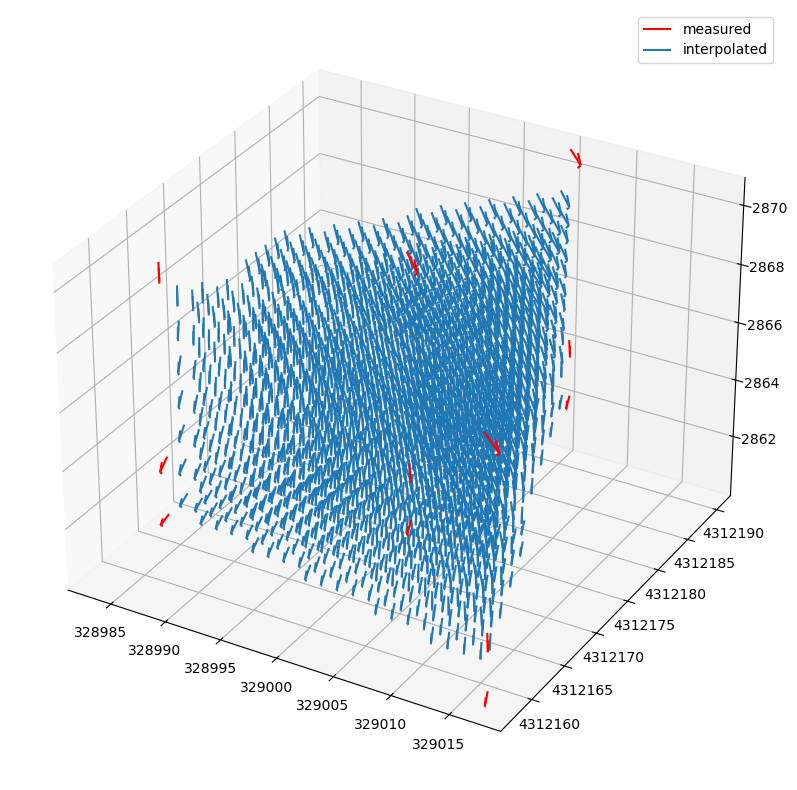

In [90]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

for i in [0]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.quiver(
        points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z, 
        points_and_wind_fields.u, points_and_wind_fields.v, points_and_wind_fields.w,
        color='red', label='measured', pivot='middle'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, zz, u_interp, v_interp, w_interp, label='interpolated', pivot='middle')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

## 3D divergence calculations (volumetric)

In [91]:
def divergence(f,sp):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [92]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
mean_divergences_lateral_bylayer = []
for i in range(0, wind_field_df.shape[0]):
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))

assert len(wind_field_df) == len(mean_divergences)
windfield_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=wind_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3212666418.py:45: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3212666418.py:45: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3212666418.py:45: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3212666418.py:45: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3212666418.py:45: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


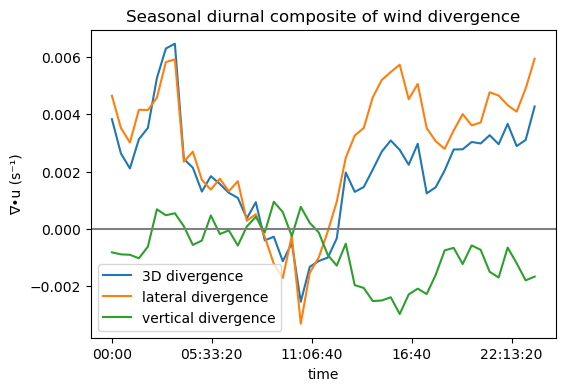

In [93]:
windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•u (s⁻¹)")
plt.title("Seasonal diurnal composite of wind divergence")
plt.legend()

<Axes: xlabel='time'>

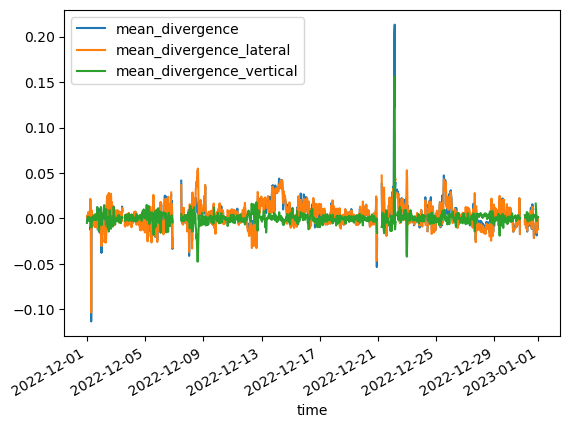

In [94]:
windfield_div_df.loc['20221201': '20221231'].plot()

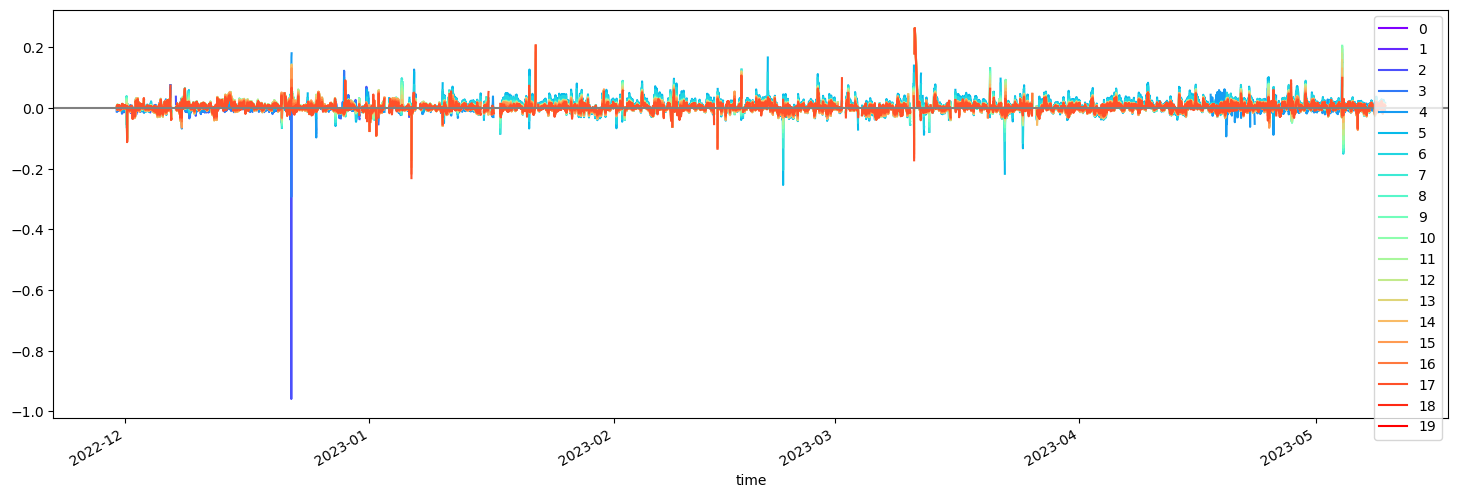

In [95]:
src = pd.DataFrame(mean_divergences_lateral_bylayer)
src.index = wind_field_df.index
src.plot(figsize=(18,6), colormap='rainbow')
plt.axhline(0, color='grey')

## 3D divergence calculations (advected water vapor)

In [96]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, adv_flux_field_df.shape[0]):
    adv_flux_field_vals = pd.DataFrame(adv_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(adv_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-1, 
        points_and_wind_fields.x.max()+1, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-1, 
        points_and_wind_fields.y.max()+1, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(adv_flux_field_df) == len(mean_divergences)
adv_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=adv_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


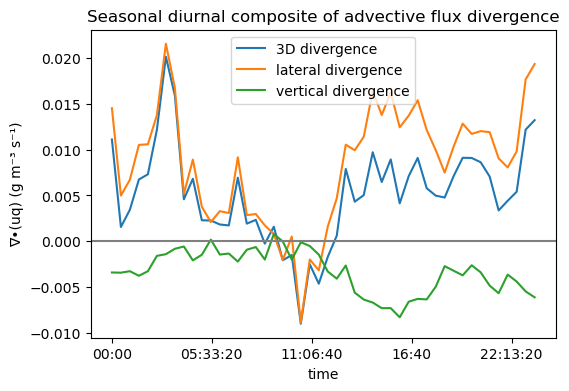

In [97]:
adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

## 3D divergence calculations (turb. diffused water vapor)

In [98]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, turb_flux_field_df.shape[0]):
    turb_flux_field_vals = pd.DataFrame(turb_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(turb_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-1, 
        points_and_wind_fields.x.max()+1, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-1, 
        points_and_wind_fields.y.max()+1, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u_h2o_, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v_h2o_, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w_h2o_, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(turb_flux_field_df) == len(mean_divergences)
turb_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=turb_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


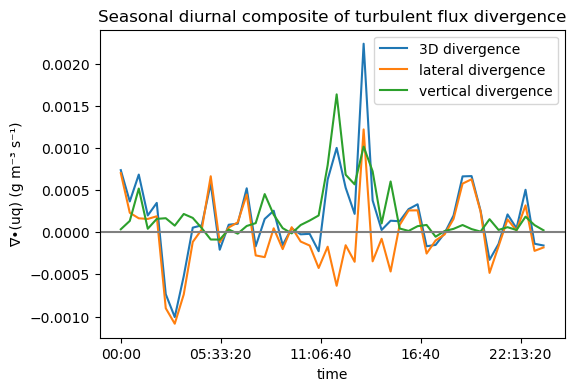

In [99]:
turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of turbulent flux divergence")
plt.legend()

In [100]:
display(turb_flux_div_df.head())
display(adv_flux_div_df.head())
display(windfield_div_df.head())

,mean_divergence,mean_divergence_lateral,mean_divergence_vertical
time,,,
2022-11-30 00:00:00,-0.000383,-0.000511,0.000129
2022-11-30 00:30:00,-0.000182,-0.000299,0.000117
2022-11-30 01:00:00,-0.000095,-0.000090,-0.000004
2022-11-30 01:30:00,-0.000010,-0.000054,0.000044
2022-11-30 02:00:00,-0.000454,-0.000436,-0.000018


,mean_divergence,mean_divergence_lateral,mean_divergence_vertical
time,,,
2022-11-30 00:00:00,0.003368,0.004452,-0.001084
2022-11-30 00:30:00,0.006168,0.003294,0.002874
2022-11-30 01:00:00,0.009325,0.008837,0.000488
2022-11-30 01:30:00,0.006961,0.011619,-0.004658
2022-11-30 02:00:00,0.005432,0.002477,0.002955


,mean_divergence,mean_divergence_lateral,mean_divergence_vertical
time,,,
2022-11-30 00:00:00,0.000871,-0.000234,0.001105
2022-11-30 00:30:00,0.000180,-0.002994,0.003174
2022-11-30 01:00:00,0.006452,0.005307,0.001145
2022-11-30 01:30:00,0.003361,0.006294,-0.002933
2022-11-30 02:00:00,-0.001457,-0.004787,0.003331


# Plot all results

In [101]:
combo_df = pd.concat([
    turb_flux_div_df.assign(type='turb_flux'),
    adv_flux_div_df.assign(type='adv_flux'),
    windfield_div_df.assign(type='windfield')
])


In [109]:
combo_df_composite = combo_df[combo_df.index.isin(nobs_times)]
combo_df_composite = combo_df_composite.groupby([combo_df_composite.index.floor('30T').time, 'type']).median().reset_index().rename(columns={'level_0':'time'})
combo_df_composite['time'] = combo_df_composite['time'].apply(lambda t: dt.datetime.combine(dt.datetime(2024,2,1), t))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/625083970.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  combo_df_composite = combo_df_composite.groupby([combo_df_composite.index.floor('30T').time, 'type']).median().reset_index().rename(columns={'level_0':'time'})


In [204]:
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("w'q' (g/m^2/s)"),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['airdensity_3m_c', 'airdensity_10m_c', 'airdensity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['specifichumidity_3m_c', 'specifichumidity_10m_c', 'specifichumidity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
).resolve_scale(color='independent').configure_legend(orient='top').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [208]:
(
    alt.Chart(combo_df.reset_index()).transform_filter(
        alt.datum.type == 'windfield'
    ).transform_fold([
        'mean_divergence',
        'mean_divergence_lateral',
        'mean_divergence_vertical'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/3/s)'),
        alt.Column('type:N'),
        alt.Color('key:N')
    ).properties(width=150, height = 150) 
    | 
    alt.Chart(combo_df.reset_index()).transform_filter(
        alt.datum.type != 'windfield'
    ).transform_fold([
        'mean_divergence',
        'mean_divergence_lateral',
        'mean_divergence_vertical'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
        alt.Column('type:N'),
        alt.Color('key:N')
    ).properties(width=150, height = 150).resolve_scale(y='independent')
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Compare with results from the Control Volume approach

In [ ]:
cv_df = pd.read_csv('flux_divergence_3d_control_volume.csv').set_index('time')
cv_df.index = pd.to_datetime(cv_df.index)
cv_df.columns[-16:]

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_adv_divergence (g/s)'].plot()
adv_flux_div_df.groupby(adv_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
zz.max() - zz.min()

In [ ]:
cv_df.head()

In [ ]:

windfield_div_df